# Test Robustness of Different Models

In [20]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor

from context import *
from LocalLearning import ModelFactory, HiddenLayerModel, KHModel, SHLP, FKHL3
from LocalLearning.Data import BaselineAccurateTestData, LpUnitCIFAR10, DeviceDataLoader
from LocalLearning.Attacks import AdversarialAttack, WhiteGaussianPerturbation, FGSM, PGD, AttackTest
from LocalLearning.Experiments import PerturbationExperiment, RandomPerturbationExperiment, FGSMExperiment, PGDExperiment
from LocalLearning import Trainers

from pathlib import Path
from collections import OrderedDict
import pickle as pkl

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use(['seaborn-paper', "../stlsheets/ICLRFullTextwidthFigureStyle.mplstyle"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# path variables
# model directory
directory = Path("../data/repro/models")
figure_directory = Path("../data/repro/figures")

# model filenames
khmodel_name = Path("khmodel_cifar10_repro_pruned.pty")
shlp_name = Path("shlp_cifar10.pty")
shlp_l2_name = Path("shlp_l2.pty")
shlp_jreg_name = Path("shlp_jreg.pty")
shlp_specreg_name = Path("shlp_specreg.pty")

fn_list = [khmodel_name, shlp_name, shlp_l2_name, shlp_jreg_name, shlp_specreg_name]

rp_fname = Path("random_perturbation_results.pkl")
fgsm_fname = Path("fgsm_results.pkl")
pgd_fname = Path("pgd_results.pkl")

# hyper parameters
BATCH_SIZE = 1000

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
cifar10Test = LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=FKHL3.pSet["p"],
)

Files already downloaded and verified


In [5]:
ce_loss = torch.nn.CrossEntropyLoss()
eps = np.logspace(-6, np.log(2.5), num=400)

rpE = RandomPerturbationExperiment(ce_loss)
rpE.run(directory, fn_list, cifar10Test, eps, device, norm_p=2.0)
rpE.save(directory / rp_fname)

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

In [6]:
fgsmE = FGSMExperiment(ce_loss)
fgsmE.load(directory / fgsm_fname)

pgdE = PGDExperiment(ce_loss)
pgdE.load(directory / pgd_fname)

In [7]:
clrs = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
names = ['KH', 'BP', 'L2', 'JReg', 'SpecReg']

def plotPerturbationResults(axs, exp: PerturbationExperiment, names: list, clrs: list) -> tuple:
    crit_norm = []
    left_ax, right_ax = axs
    #fig, axs = plt.subplots(1, 2)
    for i, (key, results) in enumerate(exp):
        left_ax.semilogx(results['eps'], results['acc'], color=clrs[i], label=names[i])
        #crit_eps.append(results['crit_eps'])
        # clean nans from data
        cns_nan = np.isnan(results['crit_eps'])
        crit_norm.append(results['crit_norm'][~cns_nan])
    #axs[1].boxplot(crit_eps, labels=names, showfliers=False)
    right_ax.boxplot(crit_norm, labels=names, showfliers=False)
    left_ax.legend(
        handlelength=0.5,
    )
    left_ax.set_xlabel(r"$\epsilon$")
    left_ax.set_ylabel("Rel. accuracy")
    right_ax.set_ylabel(r"$\| \Delta x \|_{\textrm{crit}}$")
    
    return left_ax, right_ax

/tmp/ipykernel_193516/1697747999.py:31: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(figure_directory / Path("AdversarialResults.pdf"))
/tmp/ipykernel_193516/1697747999.py:32: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(Path("AdversarialResults.pdf"))
/home/konstantin/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


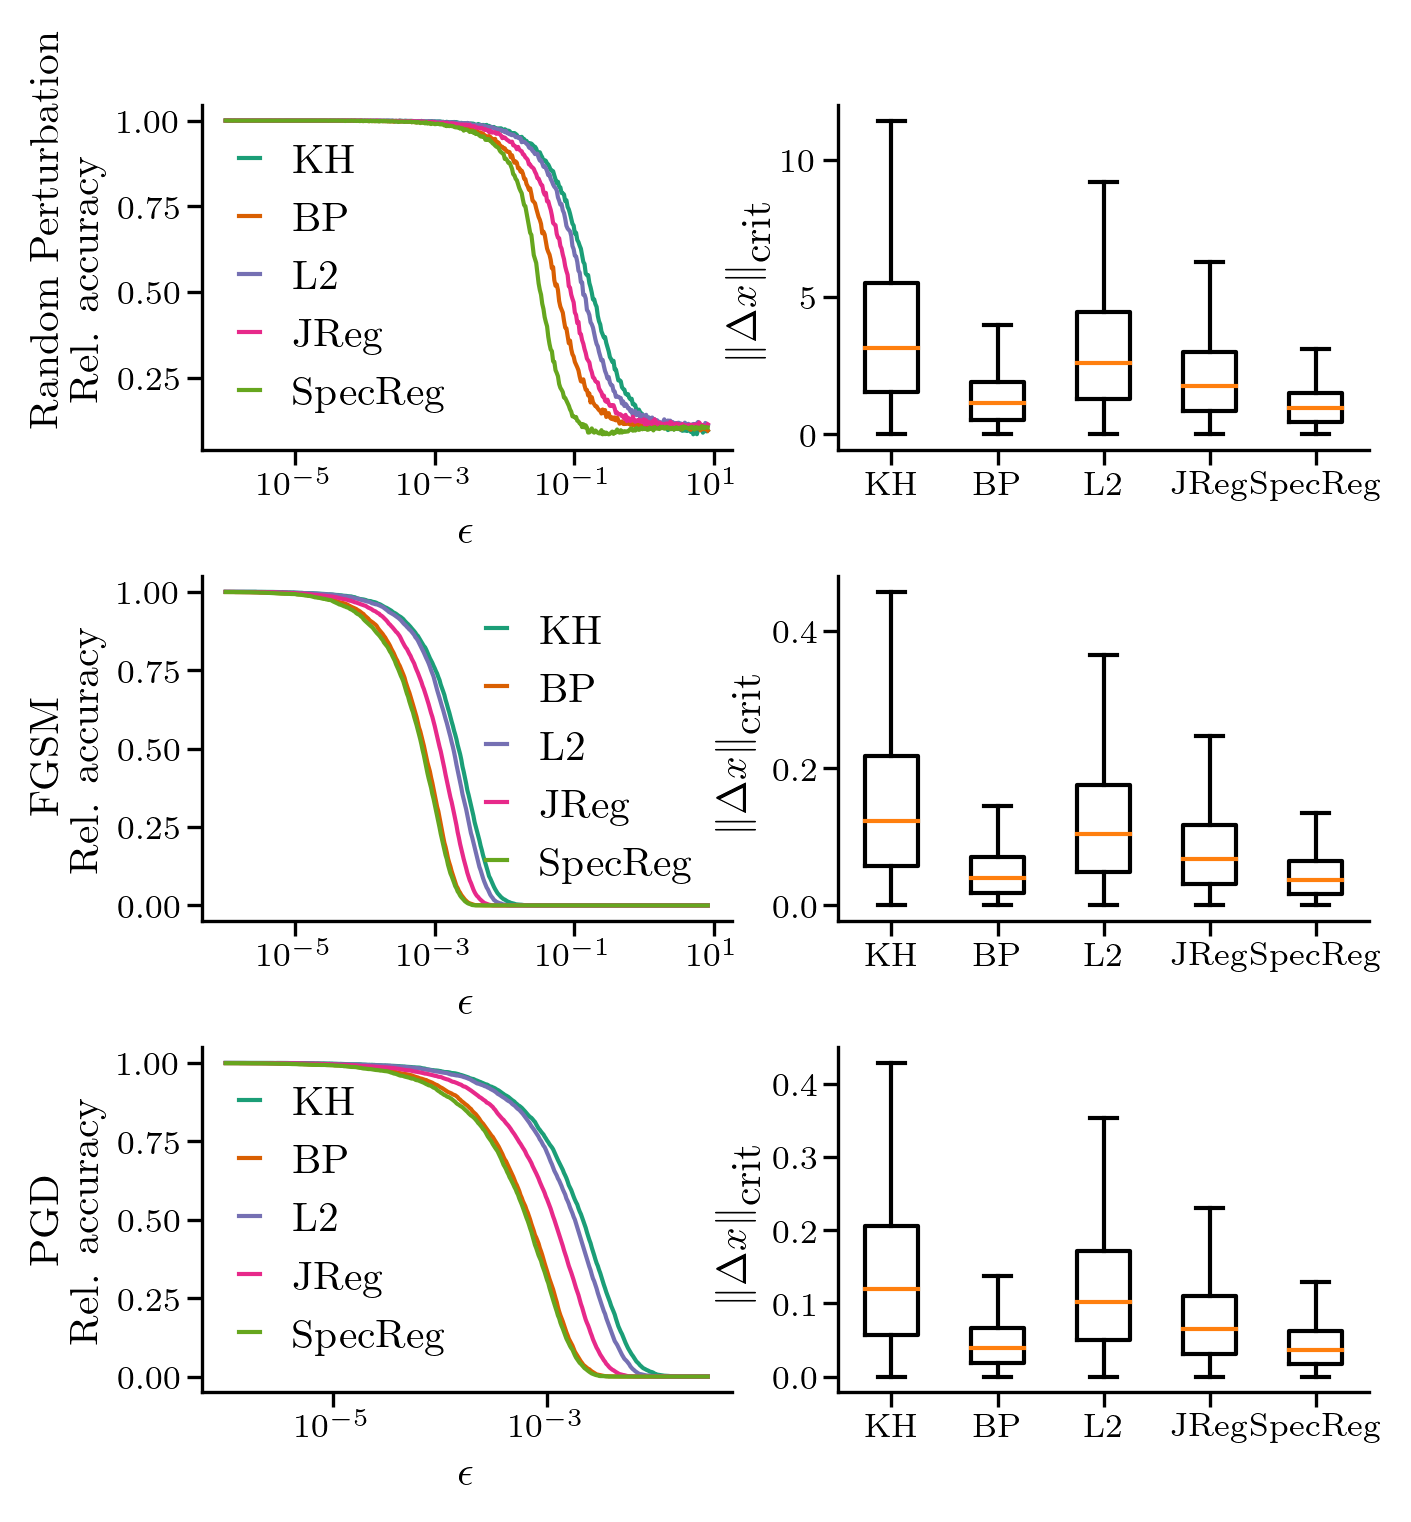

In [9]:
fig = plt.figure(constrained_layout=True)
fig.set_figheight(6.0)
width_ratios = [5e-3, 0.5, 0.5]
height_ratios = [0.05, 1.0, 0.05, 1.0, 0.05, 1.0]
gs = mpl.gridspec.GridSpec(6, 3, width_ratios=width_ratios, height_ratios=height_ratios)

RP_left_ax = fig.add_subplot(gs[1, 1])
RP_right_ax = fig.add_subplot(gs[1, 2])
RP_left_ax, RP_right_ax = plotPerturbationResults(
    (RP_left_ax, RP_right_ax),
    rpE, names, clrs,
)

fgsm_left_ax = fig.add_subplot(gs[3, 1])
fgsm_right_ax = fig.add_subplot(gs[3, 2])
fgsm_left_ax, fgsm_right_ax = plotPerturbationResults(
    (fgsm_left_ax, fgsm_right_ax),
    fgsmE, names, clrs,
)

pdg_left_ax = fig.add_subplot(gs[5, 1])
pdg_right_ax = fig.add_subplot(gs[5, 2])
pdg_left_ax, pdg_right_ax = plotPerturbationResults(
    (pdg_left_ax, pdg_right_ax),
    pgdE, names, clrs,
)

fig.text(0.1, 0.665, r"Random Perturbation", rotation='vertical', ha='center')
fig.text(0.1, 0.45, r"FGSM", rotation='vertical', ha='center')
fig.text(0.1, 0.2, r"PGD", rotation='vertical', ha='center')
fig.savefig(figure_directory / Path("Figure1-AdversarialResults.eps"))
#fig.savefig(Path("AdversarialResults.pdf"))

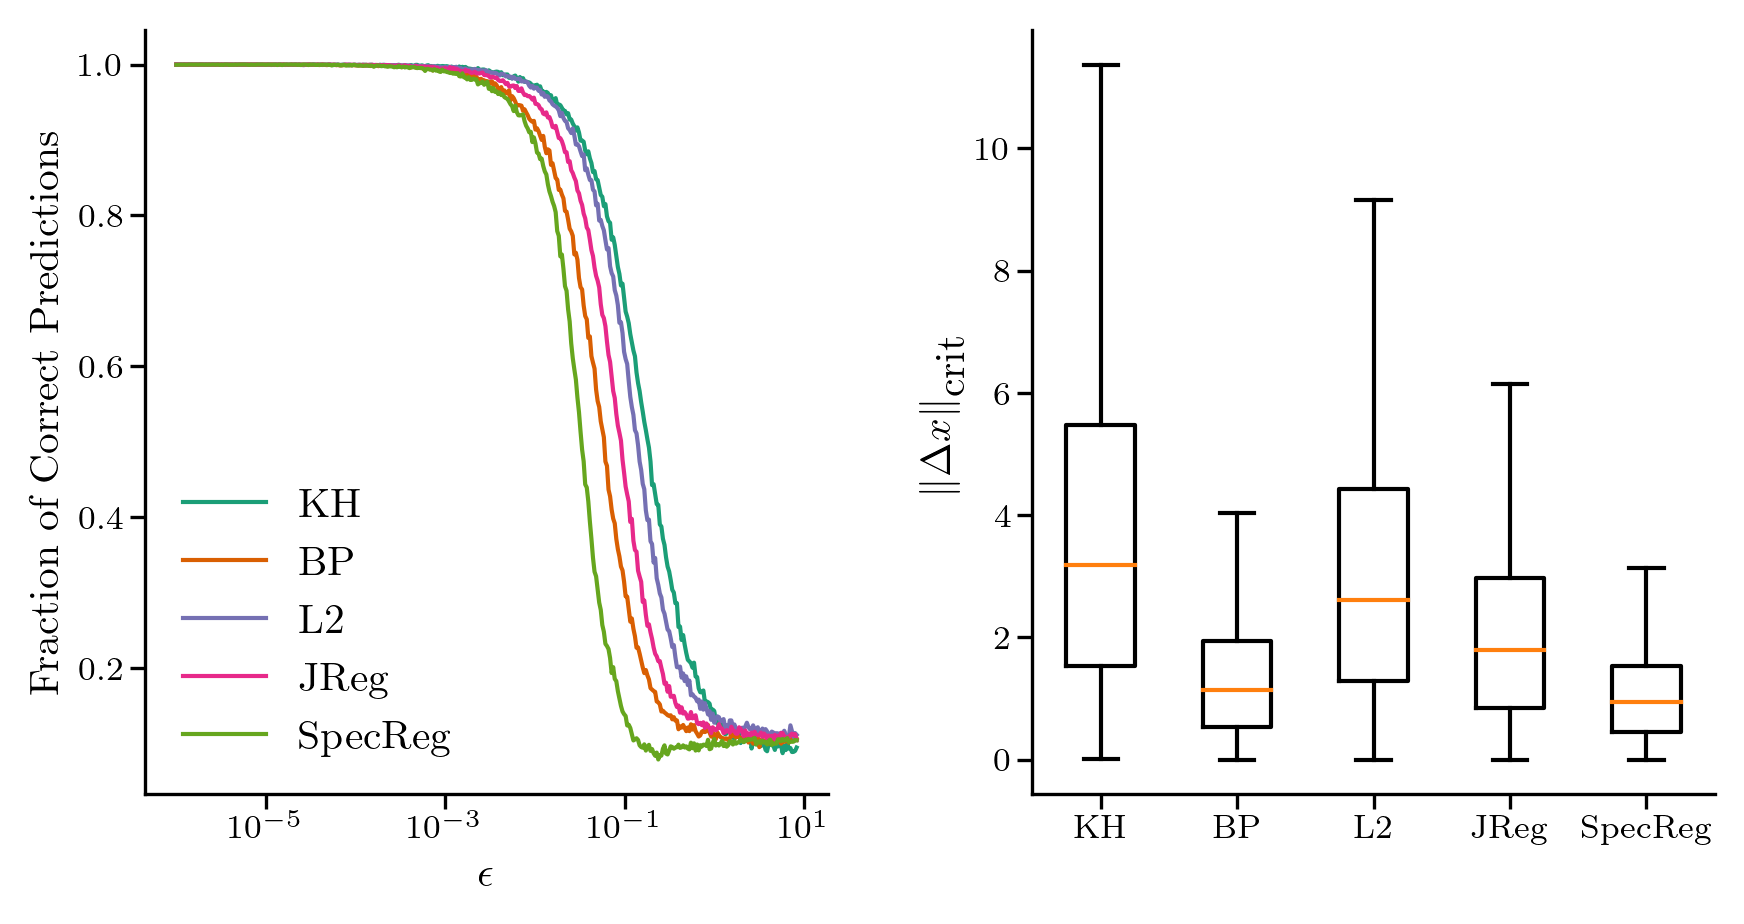

In [11]:
fig, axs = PlotResults(rpE, names, clrs)
plt.savefig(figure_directory / Path("RandomPerturbationStats.pdf"))

In [12]:
eps_fgsm = np.logspace(-6, -1.5, num=400)

fgsmE = FGSMExperiment(ce_loss)
fgsmE.run(directory, fn_list, cifar10Test, eps_fgsm, device, norm_p=2.0)
fgsmE.save(directory / fgsm_fname)

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

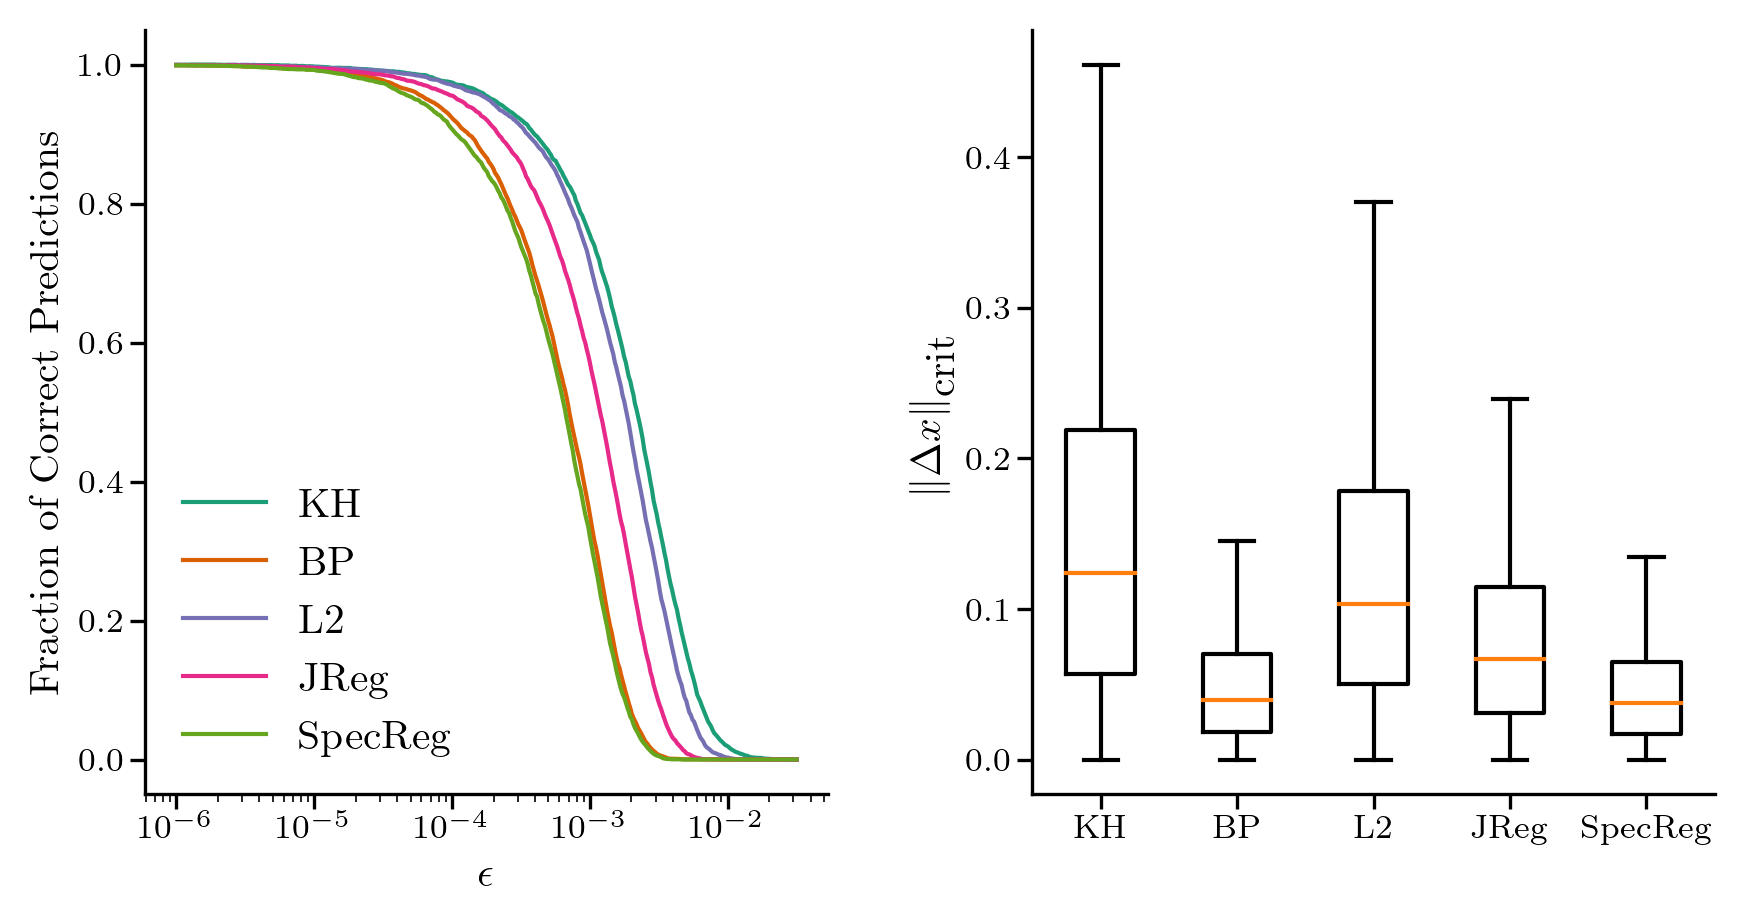

In [ ]:
fig, axs = PlotResults(fgsmE, names, clrs)
fig.savefig(figure_directory / Path("FGSMStats.pdf"))

In [ ]:
eps_pgd = np.logspace(-6, -1.5, num=400)

pgdE = PGDExperiment(ce_loss)
pgdE.run(directory, fn_list, cifar10Test, eps_pgd, device, norm_p=2.0)
pgdE.save(directory / pgd_fname)

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

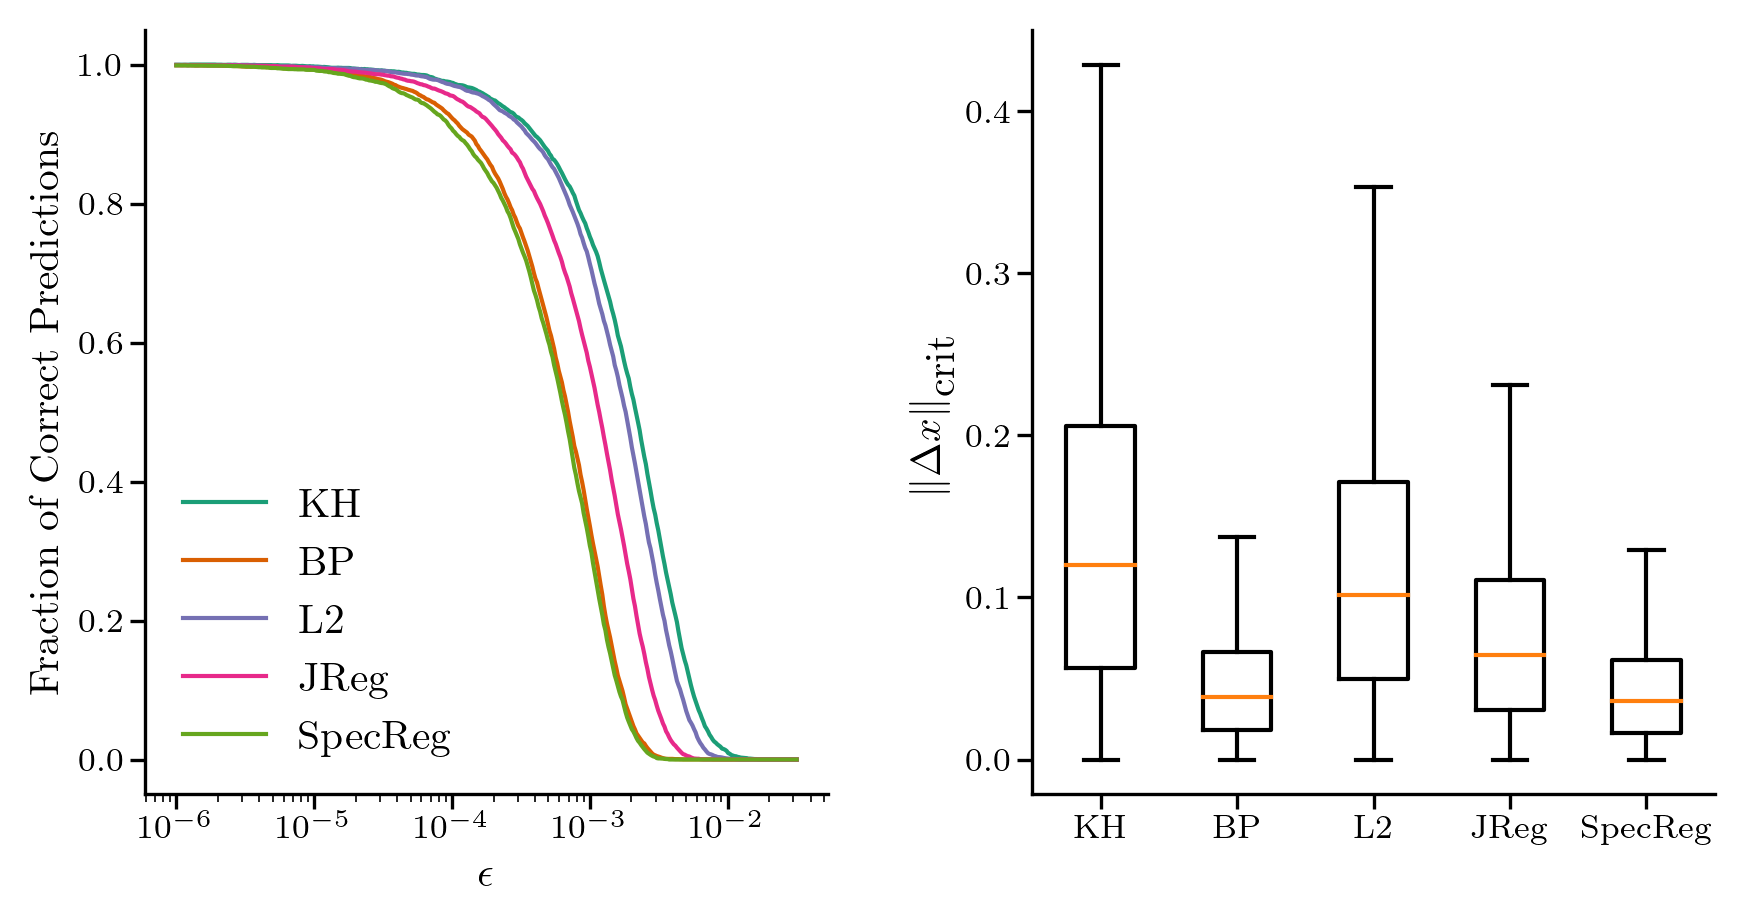

In [ ]:
fig, axs = PlotResults(pgdE, names, clrs)
fig.savefig(figure_directory / Path("PGDStats.pdf"))

In [26]:
# file names of the training log files
khmodel_log_name = Path("khmodel_cifar10_log.json")
shlp_log_name = Path("shlp_cifar10_log.json")
shlp_l2_log_name = Path("shlp_l2_log.json")
shlp_jreg_log_name = Path("shlp_jreg_log.json")
shlp_specreg_log_name = Path("shlp_specreg_log.json")

fn_log_list = [khmodel_log_name, shlp_log_name, shlp_l2_log_name, shlp_jreg_log_name, shlp_specreg_log_name]

model_accuracy = {}

for name, log_file in zip(names, fn_log_list):
    log = Trainers.Trainer.Logger()
    log.load(directory / log_file)
    model_accuracy[name] = log['eval_acc'][-1]

In [36]:
def plotAccVSRobustness(ax, exp: PerturbationExperiment, names: list, clrs: list, acc: dict):
    
    for i, (key, results) in enumerate(exp):
        cns_nan = np.isnan(results['crit_eps'])
        median = np.median(results['crit_norm'][~cns_nan])
        acc_array = np.array([acc[names[i]]])
        ax.scatter(acc_array, median, label=names[i], c=clrs[i])
    #ax.set_xlabel(r"Test accuracy")
    #ax.set_ylabel(r"$\| \Delta x \|_{\textrm{crit}}$")
    return ax

/tmp/ipykernel_193516/2284606359.py:34: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(figure_directory / Path("AccVsRobustness.pdf"))
/tmp/ipykernel_193516/2284606359.py:35: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(Path("AccVsRobustness.pdf"))


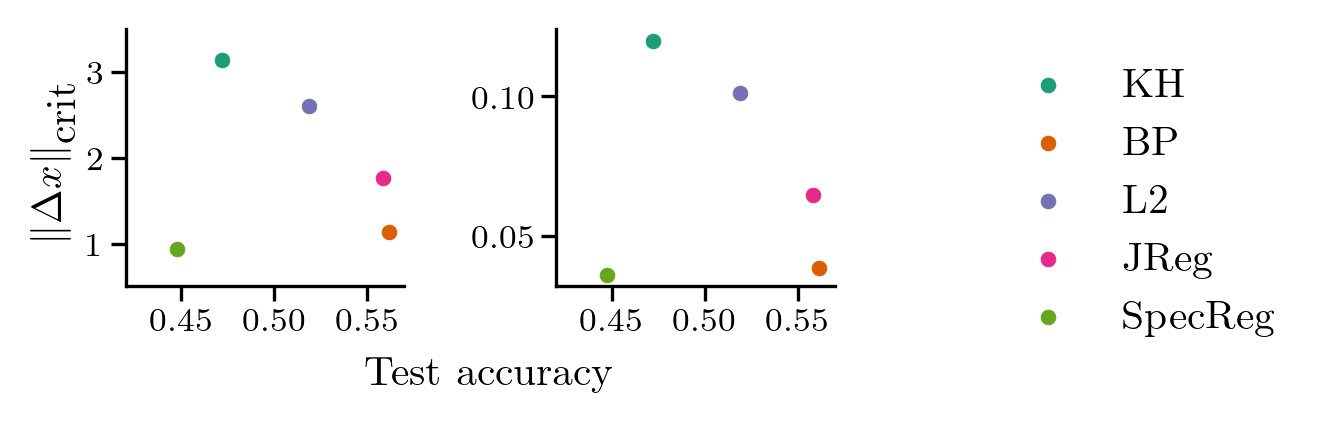

In [81]:
# accuracy - robustness plots

fig = plt.figure(constrained_layout=True)
fig.set_figheight(1.5)
width_ratios = [0.05, 0.5, 0.05, 0.5, 0.75]
height_ratios = [0.05, 1.0, 0.05]
gs = mpl.gridspec.GridSpec(3, 5, width_ratios=width_ratios, height_ratios=height_ratios)

RP_ax = fig.add_subplot(gs[1, 1])
RP_ax = plotAccVSRobustness(
    RP_ax,
    rpE, names, clrs, model_accuracy
)
RP_ax.set_xlim(0.42, 0.57)
RP_ax.set_ylim(0.5, 3.5)
RP_ax.set_ylabel(r"$\| \Delta x \|_{\textrm{crit}}$")

pgd_ax = fig.add_subplot(gs[1, 3])
pgd_ax = plotAccVSRobustness(
    pgd_ax,
    pgdE, names, clrs, model_accuracy
)
pgd_ax.set_xlim(0.42, 0.57)
handles, labels = pgd_ax.get_legend_handles_labels()
fig.text(0.4, 0.0, r"Test accuracy", rotation='horizontal', ha='center')

legend_ax = fig.add_subplot(gs[1, 4])
legend_ax.axis("off")
legend_ax.legend(handles, labels)

#fig.text(0.1, 0.665, r"Random Perturbation", rotation='vertical', ha='center')
#fig.text(0.1, 0.45, r"FGSM", rotation='vertical', ha='center')
#fig.text(0.1, 0.2, r"PGD", rotation='vertical', ha='center')
fig.savefig(figure_directory / Path("FigureA2-AccVsRobustness.pdf"))
#fig.savefig(Path("AccVsRobustness.pdf"))